# Airbnb Price Prediction

## Installing requirements

In [1]:
import pandas as pd
import numpy as np

from tensorflow.keras.models import load_model
import re 

import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr 
from sklearn.model_selection import train_test_split

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import itertools
import time
from tqdm import tqdm

from sklearn.decomposition import PCA
from sklearn import model_selection

from sklearn.model_selection import GridSearchCV

## Data preprocessing

### Exploring the data

In [2]:
# Importing the training data

data = pd.read_csv('../../data/train_airbnb_berlin.csv', delimiter = ',')
data.head()

,Listing ID,Listing Name,Host ID,Host Name,Host Since,Host Response Time,Host Response Rate,Is Superhost,neighbourhood,Neighborhood Group,...,Overall Rating,Accuracy Rating,Cleanliness Rating,Checkin Rating,Communication Rating,Location Rating,Value Rating,Instant Bookable,Business Travel Ready,Price
0,19665213.0,*,156079597.0,Maximilian,2016-01-20,NaN,NaN,f,Prenzlauer Berg,Pankow,...,100.0,10.0,10.0,10.0,10.0,9.0,10.0,t,f,26.0
1,6436842.0,*,5302290.0,Dulie,2013-04-07,NaN,NaN,f,Pankow,Pankow,...,90.0,9.0,9.0,10.0,10.0,9.0,10.0,f,f,41.0
2,10559468.0,*,59151456.0,Geank,2016-02-07,NaN,NaN,f,Prenzlauer Berg,Pankow,...,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,f,50.0
3,27215482.0,*,193452785.0,Alix,2018-06-26,NaN,NaN,f,Friedrichshain,Friedrichshain-Kreuzberg,...,100.0,10.0,10.0,10.0,10.0,10.0,9.0,f,f,50.0
4,27287546.0,*,205870244.0,Lurina,2013-05-16,within a few hours,92%,t,Prenzlauer Berg,Pankow,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t,f,55.0


In [4]:
# Important preprocessing: replacing all '*' strings by NaNs

data[data == '*'] = np.nan

In [5]:
# Global overview of the data

print(data.shape)
data.describe()

(15692, 39)


,Listing ID,Host ID,Latitude,Longitude,Square Feet,Reviews,Overall Rating,Accuracy Rating,Cleanliness Rating,Checkin Rating,Communication Rating,Location Rating,Value Rating,Price
count,1.569100e+04,1.569200e+04,15692.000000,15692.000000,303.000000,15692.000000,12730.000000,12721.000000,12722.000000,12719.000000,12722.000000,12721.000000,12720.000000,15683.000000
mean,1.780062e+07,6.119042e+07,52.509893,13.407334,445.900990,19.452014,94.717282,9.717475,9.328407,9.769164,9.779201,9.556874,9.458097,60.342983
std,9.952544e+06,6.739421e+07,0.031286,0.058646,414.817342,39.483853,7.069787,0.671793,1.023807,0.620347,0.619545,0.731109,0.788891,48.829687
min,2.241500e+04,1.101500e+04,52.369270,13.121400,0.000000,0.000000,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,8.000000
25%,9.052831e+06,9.274528e+06,52.488920,13.376025,0.000000,1.000000,93.000000,10.000000,9.000000,10.000000,10.000000,9.000000,9.000000,32.000000
50%,1.865037e+07,3.358182e+07,52.509100,13.417250,440.000000,5.000000,97.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,49.000000
75%,2.611308e+07,9.325677e+07,52.532713,13.439750,700.000000,17.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,70.000000
max,3.467450e+07,2.609698e+08,52.639670,13.709020,1912.000000,424.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,900.000000


In [6]:
# Exploring the features with less than 200 DISTINCT values

for feature in data.columns.tolist():
    unique_list = data[feature].unique().tolist()
    if len(unique_list) < 200:
        print(f'{feature} (n = {len(unique_list)}): \n{unique_list}\n')

Listing Name (n = 1): 
[nan]

Host Response Time (n = 5): 
[nan, 'within a few hours', 'within an hour', 'within a day', 'a few days or more']

Host Response Rate (n = 34): 
[nan, '92%', '100%', '80%', '71%', '83%', '98%', '78%', '89%', '50%', '90%', '70%', '20%', '97%', '91%', '88%', '75%', '93%', '0%', '67%', '33%', '40%', '58%', '86%', '60%', '95%', '94%', '96%', '82%', '63%', '99%', '87%', '25%', '30%']

Is Superhost (n = 3): 
['f', 't', nan]

neighbourhood (n = 63): 
['Prenzlauer Berg', 'Pankow', 'Friedrichshain', 'Mariendorf', 'Wilmersdorf', 'Kreuzberg', 'Moabit', 'NeukÃ¶lln', 'Alt-Treptow', 'SchÃ¶neberg', 'Reinickendorf', 'Mitte', 'Karlshorst', 'WeiÃ\x9fensee', 'Friedenau', 'Hansaviertel', 'Wedding', 'Charlottenburg', 'Steglitz', 'Baumschulenweg', 'Alt-HohenschÃ¶nhausen', 'Rummelsburg', 'Lichterfelde', 'OberschÃ¶neweide', 'Britz', 'Lichtenberg', 'Grunewald', 'Altglienicke', 'Westend', 'Tempelhof', 'Marzahn', 'Mahlsdorf', 'Adlershof', 'NiederschÃ¶nhausen', 'Tegel', 'Rahnsdorf', '

In [7]:
# Checking the proportion of missing values for each feature

data.isnull().sum()/data.shape[0]

Listing ID               0.000064
Listing Name             1.000000
Host ID                  0.000000
Host Name                0.001402
Host Since               0.001338
Host Response Time       0.450867
Host Response Rate       0.461955
Is Superhost             0.001466
neighbourhood            0.012937
Neighborhood Group       0.000000
City                     0.003059
Postal Code              0.070036
Country Code             0.000000
Country                  0.000000
Latitude                 0.000000
Longitude                0.000000
Is Exact Location        0.000000
Property Type            0.004780
Room Type                0.000000
Accomodates              0.001211
Bathrooms                0.001593
Bedrooms                 0.001020
Beds                     0.001275
Square Feet              0.980691
Guests Included          0.000637
Min Nights               0.015868
Reviews                  0.000000
First Review             0.172381
Last Review              0.172445
Overall Rating

The preprocessing of the data will be done in two phases: the first one, the preliminary data preprocessing, will be common to all Machine Learning approaches that will be used in this project. Since different approaches require different preprocessings, the second phase will be specific to each one.

### Preliminary data preprocessing

In [8]:
few_missing = data[["Host Since",
                    "Is Superhost",
                    "Property Type",
                    "Accomodates",
                    "Bathrooms",
                    "Bedrooms",
                    "Beds",
                    "Guests Included",
                    "Min Nights",
                    "Price"]].isnull().sum()

print(f"Missing values per feature:\n\n{few_missing}\n")

# Proportion of instances with missing values in the aforementioned features

few_missing_prop = few_missing.sum()/data.shape[0]

print(f"Proportion of instances with missing values in the aforementioned features:\n\n{few_missing_prop}")

Missing values per feature:

Host Since          21
Is Superhost        23
Property Type       75
Accomodates         19
Bathrooms           25
Bedrooms            16
Beds                20
Guests Included     10
Min Nights         249
Price                9
dtype: int64

Proportion of instances with missing values in the aforementioned features:

0.02976038745857762


The instances with missing values in the aforementioned attributes represent merely 3% of the entire dataset (as given above by *few_missing_prop*). We can therefore reasonably assume they are Missing Completely At Random (MCAR), which allows us to perform listwise deletion.

In [9]:
def preliminary_preprocessing(data):

    # We remove all features that are deemed irrelevant for the price prediction

    data_clean = data.drop(["Host ID",
                            "Listing ID",
                            "Listing Name",
                            "neighbourhood",
                            "City",
                            "Country Code",
                            "Country",
                            "Postal Code",
                            "Square Feet", 
                            "First Review",
                            "Last Review",
                            "Business Travel Ready"], axis=1)

    # Removing instances with NaNs in the aforementioned features 

    data_clean = data_clean.dropna(subset=["Host Since",
                                           "Is Superhost",
                                           "Property Type",
                                           "Accomodates",
                                           "Bathrooms",
                                           "Bedrooms",
                                           "Beds",
                                           "Guests Included",
                                           "Min Nights",
                                           "Price"])

    # Let's fill NaN values by "unknown" where we can

    data_clean = data_clean.replace({"Host Response Time": np.nan}, "unknown")

    # Replacing binary values by 0 and 1

    data_clean = data_clean.replace({"Is Superhost": "t"}, 1)
    data_clean = data_clean.replace({"Is Superhost": "f"}, 0)
    data_clean["Is Superhost"] = data_clean["Is Superhost"].astype(float)    

    data_clean = data_clean.replace({"Is Exact Location": "t"}, 1)
    data_clean = data_clean.replace({"Is Exact Location": "f"}, 0)
    data_clean["Is Exact Location"] = data_clean["Is Exact Location"].astype(float)

    data_clean = data_clean.replace({"Instant Bookable": "t"}, 1)
    data_clean = data_clean.replace({"Instant Bookable": "f"}, 0)
    data_clean["Instant Bookable"] = data_clean["Instant Bookable"].astype(float)

    # Converting certain numeric features into floats (they were strings)

    data_clean["Accomodates"] = data_clean["Accomodates"].astype(float)
    data_clean["Bathrooms"] = data_clean["Bathrooms"].astype(float)
    data_clean["Bedrooms"] = data_clean["Bedrooms"].astype(float)      
    data_clean["Beds"] = data_clean["Beds"].astype(float)          
    data_clean["Guests Included"] = data_clean["Guests Included"].astype(float)
    data_clean["Min Nights"] = data_clean["Min Nights"].astype(float)

    # String to float for 'Host Response Rate' (removing the '%')

    data_clean["Host Response Rate"] = data_clean["Host Response Rate"].str.rstrip("%").astype(float)

    # Changing host since into continous form

    data_clean["Host Since"] = pd.to_datetime(data_clean["Host Since"])
    most_recent =  max(data_clean["Host Since"])
    seniority = [(most_recent-x).days for x in data_clean["Host Since"]]
    data_clean["Host Since"] = seniority

    # One-hot encoding for categorical values

    dummies_response_time  = pd.get_dummies(data_clean[["Host Response Time"]])
    dummies_property_type = pd.get_dummies(data_clean[["Property Type"]])
    dummies_room_type = pd.get_dummies(data_clean[["Room Type"]])

    X_ = data_clean.drop(["Host Response Time", "Property Type", "Room Type"], axis=1)
    data_clean_final = pd.concat([X_, dummies_response_time, dummies_property_type, dummies_room_type], axis=1)
    
    return data_clean_final

**Nota Bene:** Since "Host Response Time" is an **ordinal** categorical feature, we would have liked to encode it with numeric values (e.g., "within an hour" = 1, "within a few hours" = 2, so that "within an hour" < "within a few hours", and so on), but because of the missing values, we had to one-hot encode it.

In [10]:
data_clean = preliminary_preprocessing(data)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbfc35bfc50>,
      dtype=object)

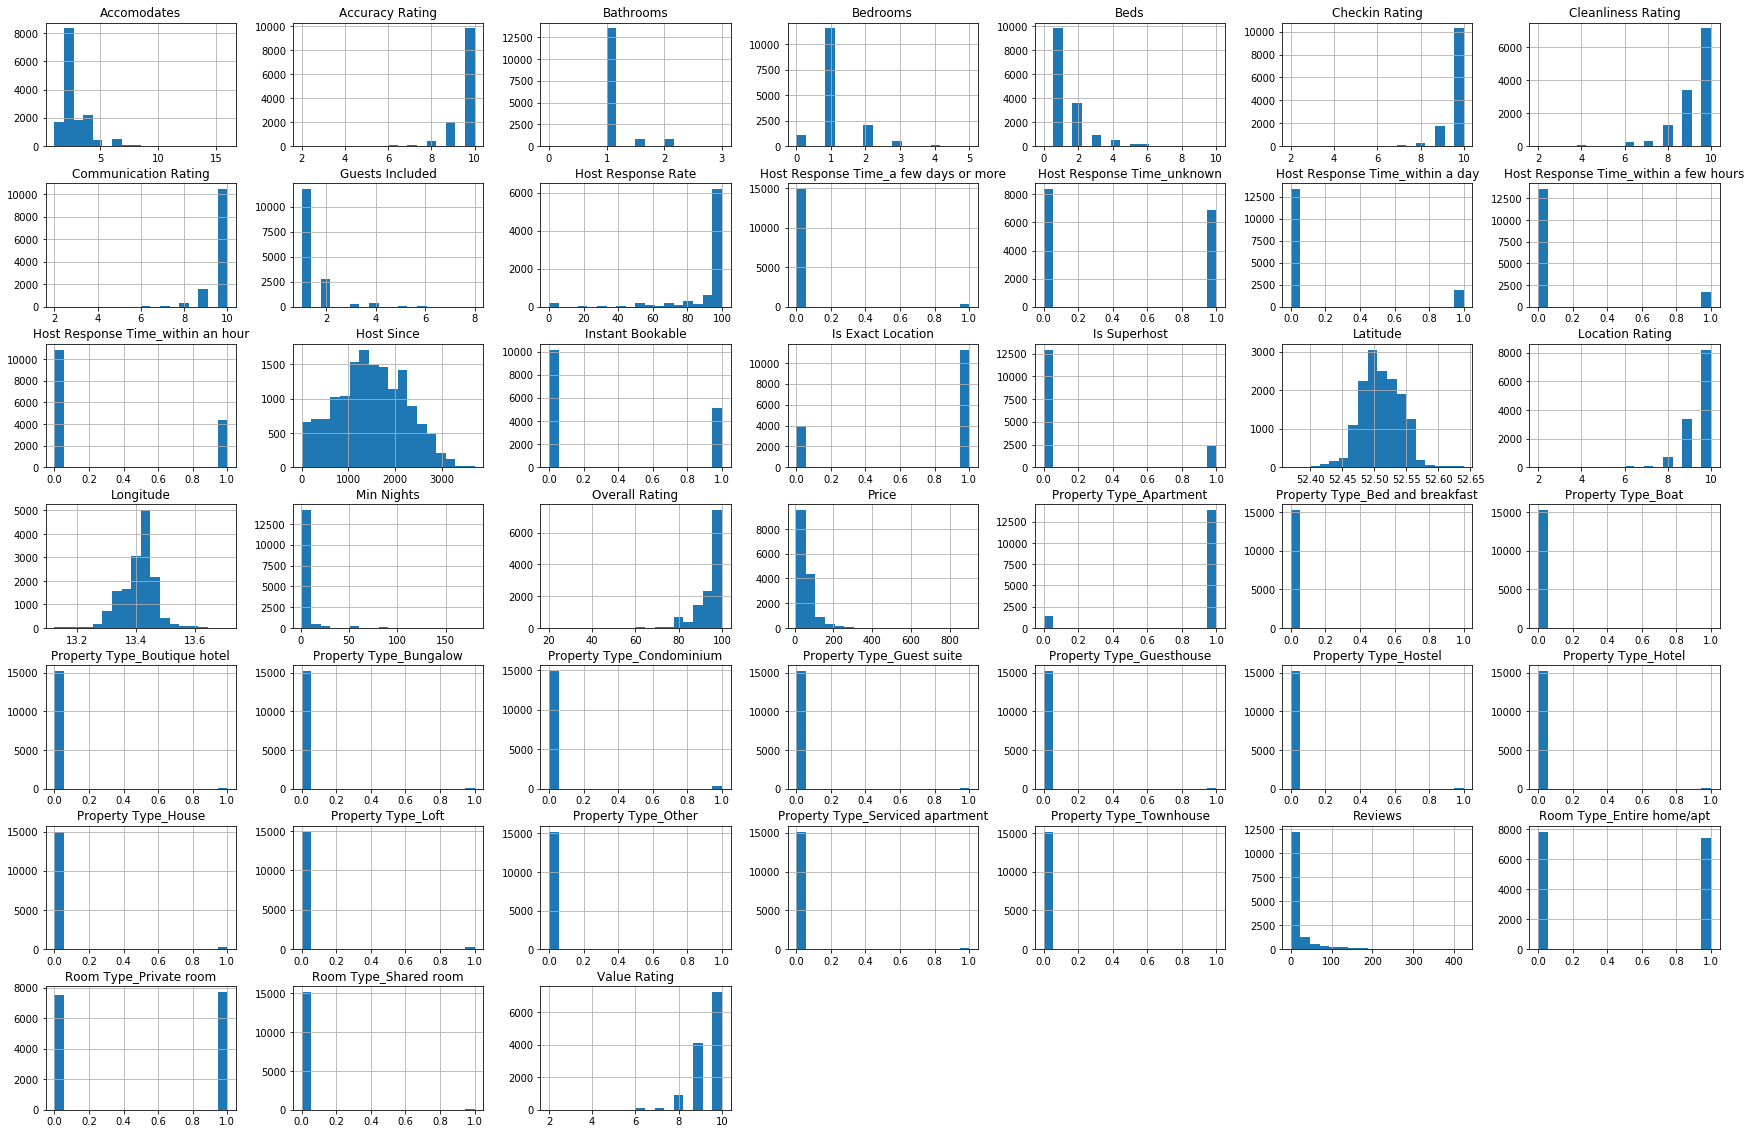

In [11]:
# Visualizing the distributions of the features in data_clean

data_clean.hist(figsize=(30,20),bins=18)

In [12]:
# Checking the proportion of missing values for the attributes where there are some left

features_missing = [feature for feature in data_clean.columns.tolist() if data_clean[feature].isna().sum()>0]
print(features_missing)

data_clean[features_missing].isna().sum()/data_clean.shape[0]

['Host Name', 'Host Response Rate', 'Overall Rating', 'Accuracy Rating', 'Cleanliness Rating', 'Checkin Rating', 'Communication Rating', 'Location Rating', 'Value Rating']


Host Name               0.000131
Host Response Rate      0.462737
Overall Rating          0.184479
Accuracy Rating         0.185069
Cleanliness Rating      0.185003
Checkin Rating          0.185200
Communication Rating    0.185003
Location Rating         0.185069
Value Rating            0.185134
dtype: float64

We see that the proportion of missing values for these features is way too high to perform listwise selection. In order to preserve our data set, we have to impute them (different strategy depending on the model).

### Adding features

#### Distance From Barycenter

In [13]:
barycenter_lat = data_clean["Latitude"].sum()/len(data_clean)
barycenter_long = data_clean["Longitude"].sum()/len(data_clean)

data_clean["Distance From Barycenter"] = np.sqrt((data_clean["Latitude"] - barycenter_lat)**2
                                                 + (data_clean["Longitude"] - barycenter_long)**2)

####  Host Gender

Let's add a feature: we process the "Host Name" feature through an NLP model to determine whether the host is male or female.

In [14]:
# Loading model 
pred_model = load_model('../../rename/boyorgirl.h5')

# Preprocessing "Host Name" feature
def preprocess(names_df):

    names_df['Host Name'] = names_df['Host Name'].apply(lambda x: 'nan' if type(x)!=type('hello') else x)
    # print(names_df['Host Name'] )

    names_df['Host Name'] = names_df['Host Name'].apply(lambda x: 'nan' if bool(re.match("^[A-Za-z0-9_-]*$",x))==False else x)
    # print(names_df['Host Name'])

    names_df['name']= names_df['Host Name']
    names_df['name'] = names_df['name'].str.lower()

    names_df['name'] = [list(name) for name in names_df['name']]

    name_length = 50
    names_df['name'] = [
        (name + [' ']*name_length)[:name_length] 
        for name in names_df['name']
    ]

    names_df['name'] = [
        [
            max(0.0, ord(char)-96.0) 
            for char in name
        ]
        for name in names_df['name']
    ]

    return names_df


# Computing prediction 
data_clean = preprocess(data_clean)

result = pred_model.predict(np.array(data_clean['name'].tolist()))

data_clean['Gender'] = ['Boy' if logit > 0.5 else 'Girl' for logit in result]

data_clean.drop('name', axis=1, inplace=True)
data_clean.drop('Host Name', axis=1, inplace=True)

dummies_gender = pd.get_dummies(data_clean[["Gender"]])

X_ = data_clean.drop("Gender", axis=1)
data_clean = pd.concat([X_, dummies_gender], axis=1)

## Train-Test Split

In [15]:
# We encode 'Neighborhood Group' classes into a one hot encoder
encoder = pd.get_dummies(data_clean['Neighborhood Group'], dtype='int64')

for feature in encoder.columns:
    data_clean[feature] = encoder[feature]

data_clean = data_clean.drop('Neighborhood Group', axis=1)

In [23]:
X, y = data_clean.drop("Price", axis=1), data_clean["Price"]

# Momentarily dropping features with missing values to compute the Pearson coefficients
X_pearson = X.drop(['Host Response Rate', 
                    'Overall Rating', 
                    'Accuracy Rating', 
                    'Cleanliness Rating',
                    'Checkin Rating',
                    'Communication Rating',
                    'Location Rating', 
                    'Value Rating'], axis=1)

pearson_coeffs = {}
for feat in X_pearson.columns:
    corr, _ = pearsonr(X_pearson[feat], y)
    pearson_coeffs[feat] = corr
    
sorted_pearson_coeffs = {k: v for k, v in sorted(pearson_coeffs.items(), key=lambda item: item[1])}

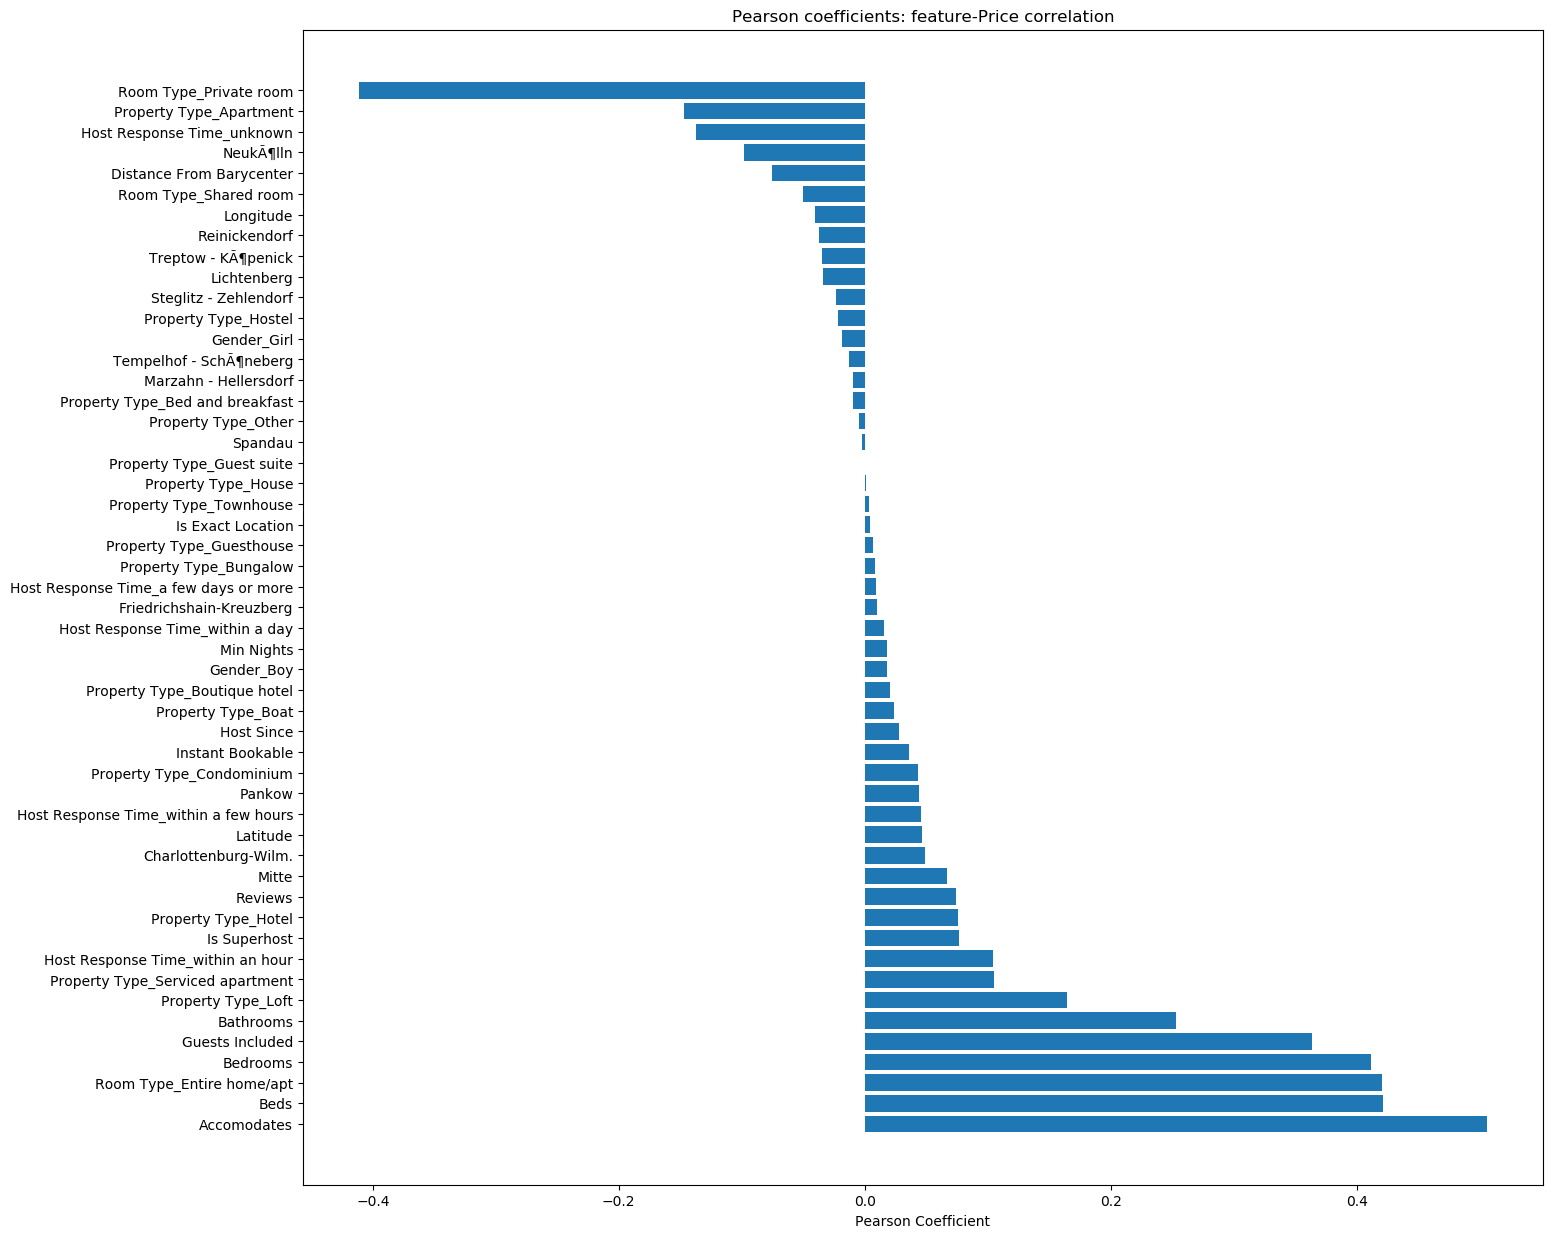

In [35]:
plt.rcdefaults()
fig, ax = plt.subplots()
fig.set_size_inches(16, 15)
performance = 100.0

cols = list(sorted_pearson_coeffs.keys())
coeffs = list(sorted_pearson_coeffs. values ())
ax.barh(np.arange(len(cols)), coeffs, align='center')
ax.set_yticks(np.arange(len(cols)))
ax.set_yticklabels(cols)
ax.invert_yaxis() # labels read top-to-bottom 
ax.set_xlabel('Pearson Coefficient')
ax.set_title('Pearson coefficients: feature-Price correlation')

plt.show()

In [56]:
train_set, test_set = train_test_split(data_clean, 
                                       test_size=0.2, 
                                       random_state=42)

In [57]:
X_train, y_train = train_set.drop("Price", axis=1), train_set['Price']
X_test, y_test = test_set.drop("Price", axis=1), test_set['Price']

## Decision Tree

### Imputation and scaling

We will begin by taking care of the remaining missing values. We will perform both univariate and multivariate feature imputation, making sure that the requirements for such methods are met.

For univariate imputation, we will use the following strategies:

- mean
- median
- most frequent value

Additionally, to avoid any bias towards dominant classes, we will perform feature scaling on numeric features using two approaches: 

- min-max scaling
- standardization

For multivariate imputation, reserved for features that are (at least) Missing At Random (MAR), we will estimate the missing values of a feature by using the observed values of all the features.

All decision trees use np.float32 arrays internally, so we need to make sure all features can be represented by floats: all the remaining nominal categorical features will be encoded into one-hot encoders.

#### Univariate imputation and scaling: choosing the best strategy

Hereafter, we define 6 pipelines for all combinations of aforementioned imputation and scaling strategies, and then choose the best one.

In [58]:
num_pipeline_mn_minmax = Pipeline([
    ('missing_mean', SimpleImputer(strategy="mean")),
    ('minmax_scaler', MinMaxScaler())
])

num_pipeline_mdn_minmax = Pipeline([
    ('missing_median', SimpleImputer(strategy="median")),
    ('minmax_scaler', MinMaxScaler())
])

num_pipeline_mf_minmax = Pipeline([
    ('missing_mf', SimpleImputer(strategy="most_frequent")),
    ('minmax_scaler', MinMaxScaler())
])

num_pipeline_mn_std = Pipeline([
    ('missing_mean', SimpleImputer(strategy="mean")),
    ('std_scaler', StandardScaler())
])

num_pipeline_mdn_std = Pipeline([
    ('missing_median', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler())
])

num_pipeline_mf_std = Pipeline([
    ('missing_mf', SimpleImputer(strategy="most_frequent")),
    ('std_scaler', StandardScaler())
])

In [59]:
# Let's get the list of numerical features (some of them need imputation, all of them need to be scaled)

numeric_features = ['Host Since',
                    'Host Response Rate',
                    'Latitude',
                    'Longitude',
                    'Accomodates',
                    'Bathrooms',
                    'Bedrooms',
                    'Beds',
                    'Guests Included',
                    'Min Nights',
                    'Reviews',
                    'Overall Rating',
                    'Accuracy Rating',
                    'Cleanliness Rating',
                    'Checkin Rating',
                    'Communication Rating',
                    'Location Rating',
                    'Value Rating']

airbnb_data_transformer_1 = ColumnTransformer([("num_mn_minmax", num_pipeline_mn_minmax, numeric_features)],
                                              remainder="passthrough")
airbnb_data_transformer_2 = ColumnTransformer([("num_mdn_minmax", num_pipeline_mdn_minmax, numeric_features)],
                                              remainder="passthrough")
airbnb_data_transformer_3 = ColumnTransformer([("num_mf_minmax", num_pipeline_mf_minmax, numeric_features)],
                                              remainder="passthrough")
airbnb_data_transformer_4 = ColumnTransformer([("num_mn_std", num_pipeline_mn_std, numeric_features)],
                                              remainder="passthrough")
airbnb_data_transformer_5 = ColumnTransformer([("num_mdn_std", num_pipeline_mdn_std, numeric_features)],
                                              remainder="passthrough")
airbnb_data_transformer_6 = ColumnTransformer([("num_mf_std", num_pipeline_mf_std, numeric_features)],
                                              remainder="passthrough")

In [60]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

def train_test_decision_tree(X_train, y_train, X_test, y_test):
    '''
    Trains and tests a decision tree regression model on the given training and test sets.
    The function prints the RMSE of the predictions on the test set for each type of
    preprocessing (6 combinations to test in total).
    
    Parameters
    ----------
        X_train : {array-like, sparse matrix}
            The matrix with the values of the features of the training instances.
        y_train : array-like
            The vector with the values of the target variable of the training instances.
        X_test : {array-like, sparse matrix}
            The matrix with the values of the features of the test instances.
        y_test : array-like
            The vector with the values of the target variable of the test instances.
    '''

    # Define the 6 types of full pipelines, combining the above preprocessors with Decision Tree Regressor
    full_pipeline_1 = Pipeline([("data_processing", airbnb_data_transformer_1),
                                ("decision_tree", DecisionTreeRegressor())])
    full_pipeline_2 = Pipeline([("data_processing", airbnb_data_transformer_2),
                                ("decision_tree", DecisionTreeRegressor())])
    full_pipeline_3 = Pipeline([("data_processing", airbnb_data_transformer_3),
                                ("decision_tree", DecisionTreeRegressor())])
    full_pipeline_4 = Pipeline([("data_processing", airbnb_data_transformer_4),
                                ("decision_tree", DecisionTreeRegressor())])
    full_pipeline_5 = Pipeline([("data_processing", airbnb_data_transformer_5),
                                ("decision_tree", DecisionTreeRegressor())])
    full_pipeline_6 = Pipeline([("data_processing", airbnb_data_transformer_6),
                                ("decision_tree", DecisionTreeRegressor())])
    
    # Transform the training data and train the Decision Tree Regressor
    full_pipeline_1.fit(X_train, y_train)
    full_pipeline_2.fit(X_train, y_train)
    full_pipeline_3.fit(X_train, y_train)
    full_pipeline_4.fit(X_train, y_train)
    full_pipeline_5.fit(X_train, y_train)
    full_pipeline_6.fit(X_train, y_train)

    # Test the Decision Tree Regressor on the test data
    predictions_1 = full_pipeline_1.predict(X_test)
    predictions_2 = full_pipeline_2.predict(X_test)
    predictions_3 = full_pipeline_3.predict(X_test)
    predictions_4 = full_pipeline_4.predict(X_test)
    predictions_5 = full_pipeline_5.predict(X_test)
    predictions_6 = full_pipeline_6.predict(X_test)

    # Compute the prediction error
    mse_1 = mean_squared_error(y_test, predictions_1)
    mse_2 = mean_squared_error(y_test, predictions_2)
    mse_3 = mean_squared_error(y_test, predictions_3)
    mse_4 = mean_squared_error(y_test, predictions_4)
    mse_5 = mean_squared_error(y_test, predictions_5)
    mse_6 = mean_squared_error(y_test, predictions_6)

    # Print the RMSE
    print("The RMSE error using pipeline 1 is:", np.sqrt(mse_1))
    print("--------------------------- \n")
    print("The RMSE error using pipeline 2 is:", np.sqrt(mse_2))
    print("--------------------------- \n")
    print("The RMSE error using pipeline 3 is:", np.sqrt(mse_3))
    print("--------------------------- \n")
    print("The RMSE error using pipeline 4 is:", np.sqrt(mse_4))
    print("--------------------------- \n")
    print("The RMSE error using pipeline 5 is:", np.sqrt(mse_5))
    print("--------------------------- \n")
    print("The RMSE error using pipeline 6 is:", np.sqrt(mse_6))
    print("--------------------------- \n")

In [61]:
train_test_decision_tree(X_train, y_train, X_test, y_test)

The RMSE error using pipeline 1 is: 55.24940179012203
--------------------------- 

The RMSE error using pipeline 2 is: 51.23929760311426
--------------------------- 

The RMSE error using pipeline 3 is: 54.728513739275066
--------------------------- 

The RMSE error using pipeline 4 is: 53.18376108078575
--------------------------- 

The RMSE error using pipeline 5 is: 50.3102131853276
--------------------------- 

The RMSE error using pipeline 6 is: 56.09917018882065
--------------------------- 



From the above results, configuration 5 (median imputation + standard normalization) seems to work best. Let us now try a mix of min-max scaling and standard normalization (for the numeric features that seem to follow a Gaussian distribution).

In [62]:
numeric_features_gaussian = ['Host Since', 'Latitude', 'Longitude']
numeric_features_nongaussian = [feat for feat in numeric_features if feat not in numeric_features_gaussian]

airbnb_data_transformer_7 = ColumnTransformer([
    ("num_mn_minmax", num_pipeline_mn_minmax, numeric_features_nongaussian),
    ("num_mn_std", num_pipeline_mn_std, numeric_features_gaussian)],
    remainder="passthrough")

airbnb_data_transformer_8 = ColumnTransformer([
    ("num_mdn_minmax", num_pipeline_mdn_minmax, numeric_features_nongaussian),
    ("num_mdn_std", num_pipeline_mdn_std, numeric_features_gaussian)],
    remainder="passthrough")

airbnb_data_transformer_9 = ColumnTransformer([
    ("num_mf_minmax", num_pipeline_mf_minmax, numeric_features_nongaussian),
    ("num_mf_std", num_pipeline_mf_std, numeric_features_gaussian)],
    remainder="passthrough")

In [63]:
def train_test_decision_tree_2(X_train, y_train, X_test, y_test):
    '''
    Trains and tests a decision tree regression model on the given training and test sets.
    The function prints the RMSE of the predictions on the test set for each type of
    preprocessing (3 combinations to test in total).
    
    Parameters
    ----------
        X_train : {array-like, sparse matrix}
            The matrix with the values of the features of the training instances.
        y_train : array-like
            The vector with the values of the target variable of the training instances.
        X_test : {array-like, sparse matrix}
            The matrix with the values of the features of the test instances.
        y_test : array-like
            The vector with the values of the target variable of the test instances.
    '''

    # Define the full pipeline, combining the above preprocessors with Decision Tree Regressor
    full_pipeline_7 = Pipeline([("data_processing", airbnb_data_transformer_7),
                                ("decision_tree", DecisionTreeRegressor())])
    full_pipeline_8 = Pipeline([("data_processing", airbnb_data_transformer_8),
                                ("decision_tree", DecisionTreeRegressor())])
    full_pipeline_9 = Pipeline([("data_processing", airbnb_data_transformer_9),
                                ("decision_tree", DecisionTreeRegressor())])
    
    # Transform the training data and train the Decision Tree Regressor
    full_pipeline_7.fit(X_train, y_train)
    full_pipeline_8.fit(X_train, y_train)
    full_pipeline_9.fit(X_train, y_train)

    # Test the Decision Tree Regressor on the test data
    predictions_7 = full_pipeline_7.predict(X_test)
    predictions_8 = full_pipeline_8.predict(X_test)
    predictions_9 = full_pipeline_9.predict(X_test)

    # Compute the prediction error
    mse_7 = mean_squared_error(y_test, predictions_7)
    mse_8 = mean_squared_error(y_test, predictions_8)
    mse_9 = mean_squared_error(y_test, predictions_9)

    # Print the RMSE
    print("The RMSE error using pipeline 7 is: ", np.sqrt(mse_7))
    print("--------------------------- \n")
    print("The RMSE error using pipeline 8 is: ", np.sqrt(mse_8))
    print("--------------------------- \n")
    print("The RMSE error using pipeline 9 is: ", np.sqrt(mse_9))
    print("--------------------------- \n")

In [64]:
train_test_decision_tree_2(X_train, y_train, X_test, y_test)

The RMSE error using pipeline 7 is:  56.456075617530175
--------------------------- 

The RMSE error using pipeline 8 is:  51.921408671707724
--------------------------- 

The RMSE error using pipeline 9 is:  53.550501291818996
--------------------------- 



Some of these errors are higher with a mix of scaling strategies (min-max + standard normalization), showing that standard normalization scaling is preferable in our case. Paired with median imputation, we obtain the lowest RMSE of all the {univariate imputation + scaling} approaches.

#### Multivariate stochastic imputation

In [65]:
it_imp = IterativeImputer(sample_posterior=True)
X_it_imp = it_imp.fit_transform(pd.concat([X_train,y_train], axis=1))

X_train_imputed = np.delete(X_it_imp, -1, axis=1)
X_train_imputed_df = pd.DataFrame(X_train_imputed,
                                  columns=list(X_train.columns))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbfab14d208>,
      dtype=object)

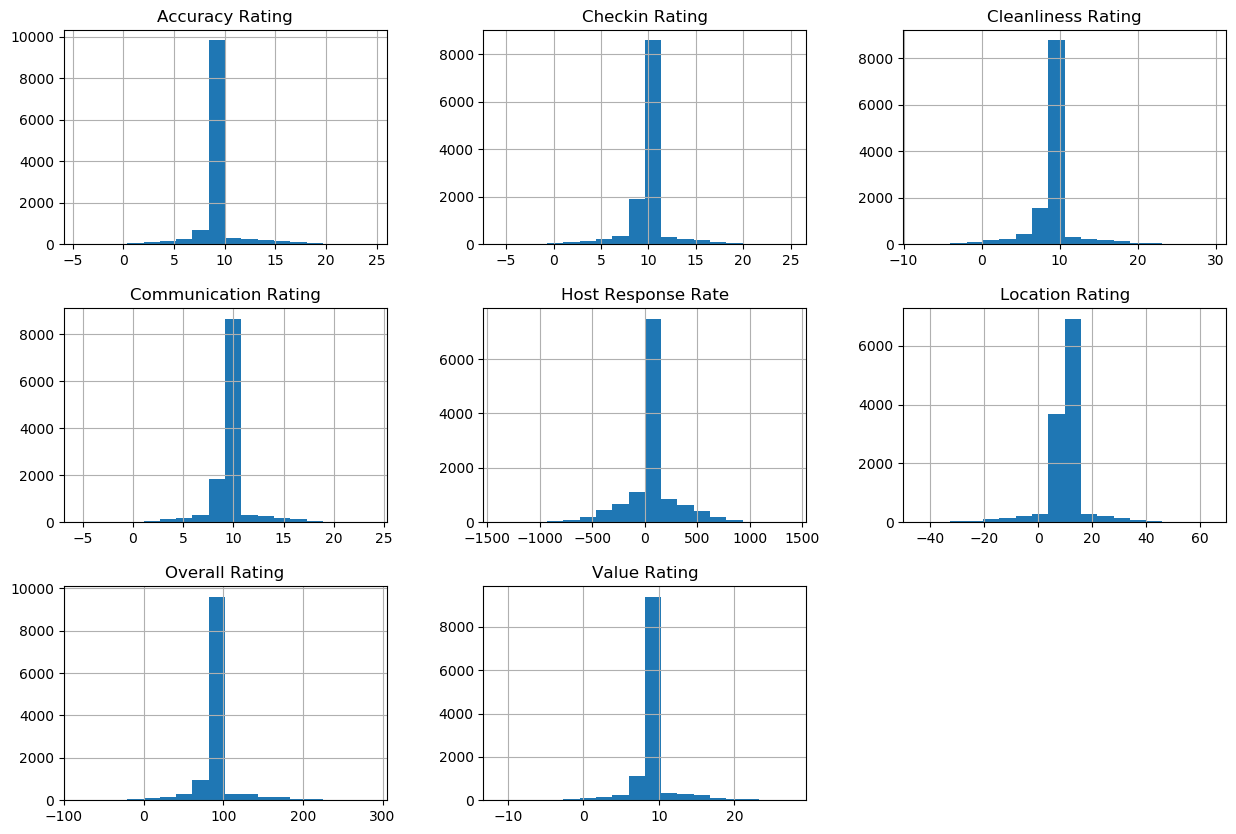

In [66]:
X_train_imputed_df.hist(column=["Host Response Rate",
                                "Overall Rating",
                                "Accuracy Rating",
                                "Cleanliness Rating",
                                "Checkin Rating",
                                "Communication Rating",
                                "Location Rating",
                                "Value Rating"], bins=18, figsize=(15,10))

Aside from the fact that all distributions are narrowly centered around 10 or 100 depending on the feature, the added Gaussian noise outputs values that exceed the 10/10 or 100% marks, which makes this stochastic imputation unusable.

### Constructing processed data with best imputation/scaling strategy

From what we have seen, the best strategy is {median imputation + min-max scaling}, represented by the following transformer: **airbnb_data_transformer_2**.

In [67]:
# The transformer reorders the features (numeric first, then categorical).
# When reconstructing the dataframe, we need to take this into account!

categorical_features = [f for f in list(X_train.columns) if f not in numeric_features]

X_train_processed_arr = airbnb_data_transformer_2.fit_transform(X_train)
X_train_processed = pd.DataFrame(X_train_processed_arr, 
                                 columns=numeric_features+categorical_features)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbf9816f390>,
      dtype=object)

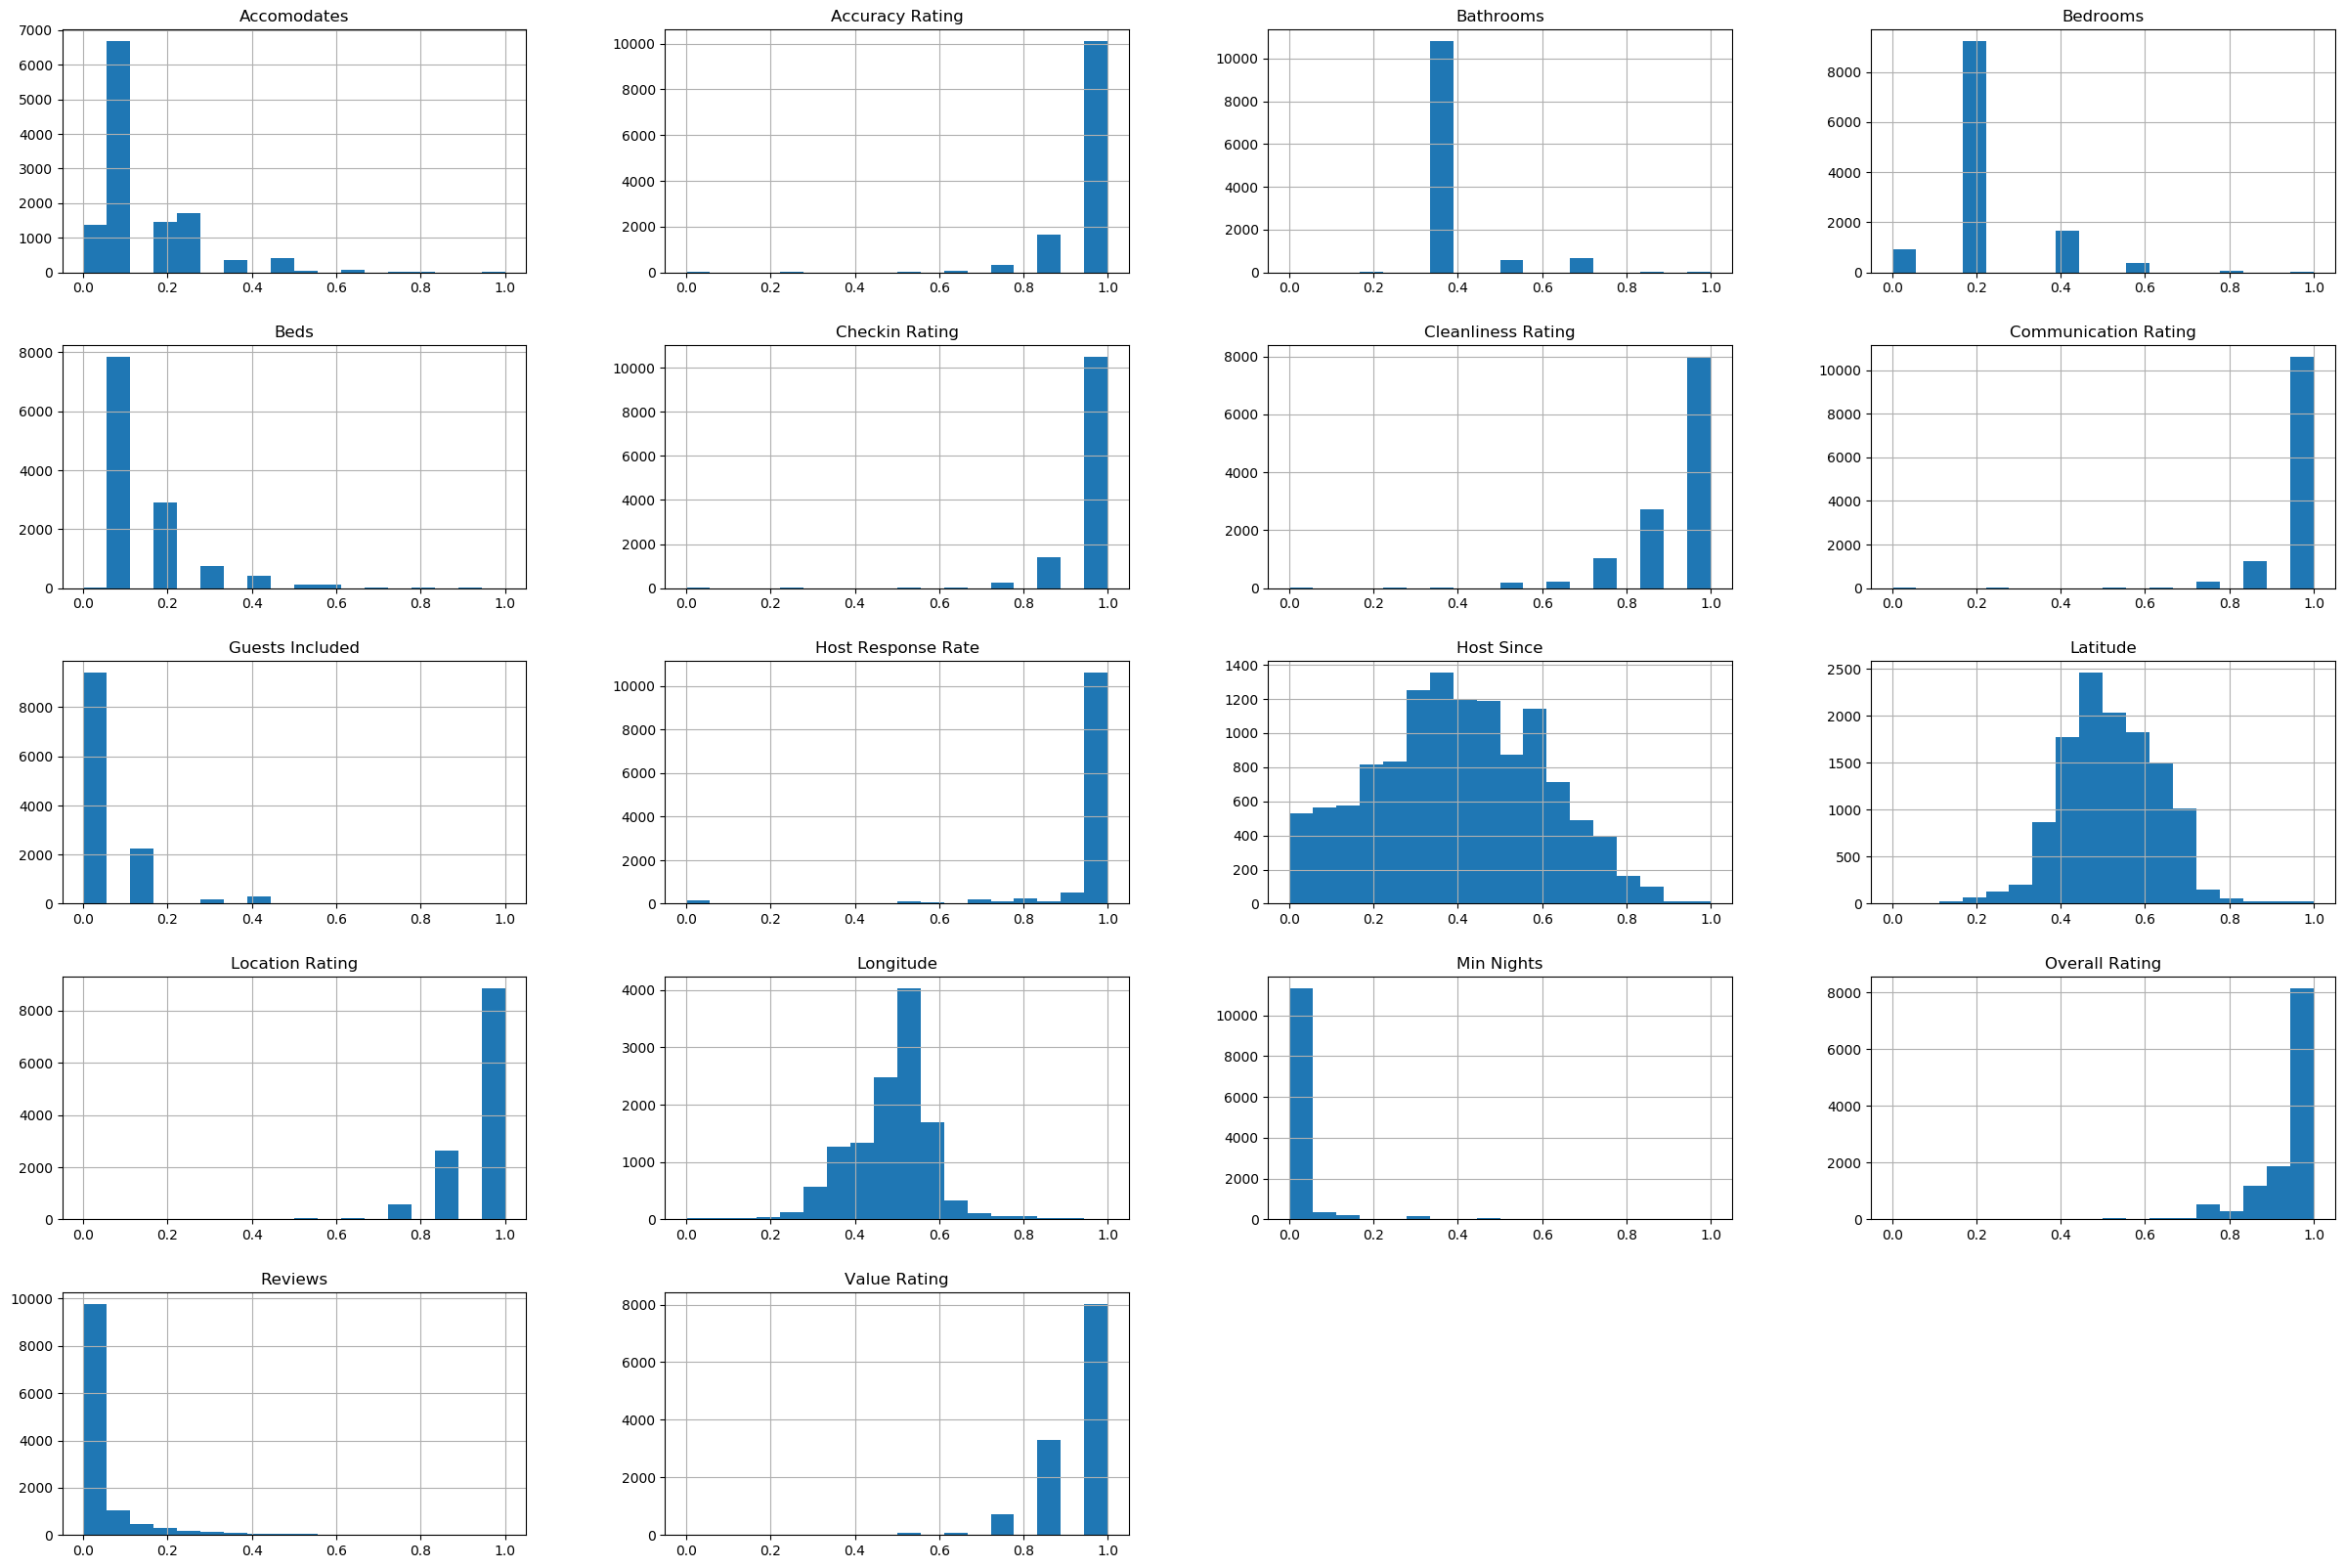

In [68]:
X_train_processed.hist(figsize=(30,20), bins=18, column=numeric_features)

In [69]:
# Likewise, let's build the processed version of X_test as well

categorical_features = [f for f in list(X_test.columns) if f not in numeric_features]

X_test_processed_arr = airbnb_data_transformer_2.fit_transform(X_test)
X_test_processed = pd.DataFrame(X_test_processed_arr, 
                                columns=numeric_features+categorical_features)

## Dimension Reduction

### Feature Selection

In [70]:
X_train = X_train_processed
X_test = X_test_processed

In [71]:
clf = tree.DecisionTreeRegressor().fit(X_train, y_train)
kf_10 = model_selection.KFold(n_splits=10, shuffle=True, random_state=0)

def processSubset(feature_set):
    
    # Fit decision tree model on feature_set and calculate score
    score = -1 * model_selection.cross_val_score(clf,
                                                 X_train[list(feature_set)],
                                                 y_train.ravel(),
                                                 cv=kf_10,
                                                 scoring='neg_mean_squared_error').mean()

    return {"model": list(feature_set), "RSS": score}

#### Best Subset Selection

This method is not computationally efficient and would therefore take too long (we have well over 40 features). Let's use other more efficient approaches instead, such as Forward Stepwise Selection (FSS) and Backward Stepwise Selection (BSS).

#### Forward Stepwise Selection

In [73]:
def forward(features):
    
    # Pull out features we still need to process
    remaining_features = [d for d in X_train.columns if d not in features]

    tic = time.time()
    
    results = []
    
    for d in remaining_features:
        results.append(processSubset(features+[d]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the lowest RSS
    best_model = models.loc[models['RSS'].idxmin()]
    
    toc = time.time()     

    print("Processed", models.shape[0], "models on", len(features)+1, "features in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [74]:
models_fwd = pd.DataFrame(columns=["model", "RSS"])

tic = time.time()
features = []

for i in range(1, len(X_train.columns)+1):
    models_fwd.loc[i] = forward(features)
    features = models_fwd.loc[i]["model"]
    # print(features)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed 59 models on 1 features in 2.3704960346221924 seconds.
Processed 58 models on 2 features in 2.523789167404175 seconds.
Processed 57 models on 3 features in 2.7287559509277344 seconds.
Processed 56 models on 4 features in 3.115571975708008 seconds.
Processed 55 models on 5 features in 3.650986671447754 seconds.
Processed 54 models on 6 features in 3.6029202938079834 seconds.
Processed 53 models on 7 features in 3.6246700286865234 seconds.
Processed 52 models on 8 features in 4.623210906982422 seconds.
Processed 51 models on 9 features in 4.230787992477417 seconds.
Processed 50 models on 10 features in 4.523687839508057 seconds.
Processed 49 models on 11 features in 4.88616681098938 seconds.
Processed 48 models on 12 features in 4.78235387802124 seconds.
Processed 47 models on 13 features in 4.735814809799194 seconds.
Processed 46 models on 14 features in 5.004814147949219 seconds.
Processed 45 models on 15 features in 4.983788013458252 seconds.
Processed 44 models on 16 featur

We now have the best model $\mathcal{M}_k$ for each number of features $k$ and want to choose the best $\mathcal{M}_k$. The $\textbf{RSS}$ values obtained previously correspond to the prediction error on the test samples (thanks to our cross-validation approach). Therefore, we will choose the model with the lowest $\textbf{RSS}$.

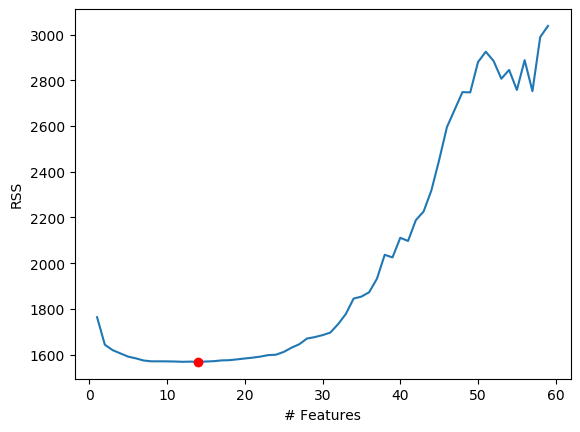

In [75]:
import matplotlib.pyplot as plt

plt.plot(models_fwd["RSS"])
plt.xlabel('# Features')
plt.ylabel('RSS')
plt.plot(models_fwd["RSS"].idxmin(), models_fwd["RSS"].min(), "or")

In [76]:
# Obtaining features of the best model according to the FSS
idx_min = models_fwd["RSS"].idxmin()
best_model_fwd = models_fwd["model"][idx_min]
best_rss_fwd = models_fwd["RSS"].min()

print(f'The best model according to the FSS is: {best_model_fwd} ({len(best_model_fwd)} features).')
print('The corresponding RSS is:', best_rss_fwd)

The best model according to the FSS is: ['Accomodates', 'Room Type_Entire home/apt', 'Bathrooms', 'Host Response Time_unknown', 'Property Type_Hotel', 'Property Type_Hostel', 'Treptow - KÃ¶penick', 'Tempelhof - SchÃ¶neberg', 'Property Type_Boutique hotel', 'Steglitz - Zehlendorf', 'Property Type_Guesthouse', 'Room Type_Private room', 'Property Type_Bungalow', 'Room Type_Shared room'] (14 features).
The corresponding RSS is: 1567.6747293899446


#### Backward Stepwise Selection

In [78]:
def backward(features):
        
    tic = time.time()
        
    results = []
    
    for combo in itertools.combinations(features, len(features)-1):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)

    # Choose the model with the lowest RSS
    best_model = models.loc[models['RSS'].idxmin()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", len(features)-1, "features in", (toc-tic), "seconds.")
        
    # Return the best model, along with some other useful information about the model
    return best_model

In [79]:
models_bwd = pd.DataFrame(columns=["model", "RSS"], index = range(1, len(X_train.columns)))

tic = time.time()
features = X_train.columns

while(len(features) > 1):  
    models_bwd.loc[len(features)-1] = backward(features)
    features = models_bwd.loc[len(features)-1]["model"]

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed 59 models on 58 features in 90.94079208374023 seconds.
Processed 58 models on 57 features in 94.04332709312439 seconds.
Processed 57 models on 56 features in 84.02592325210571 seconds.
Processed 56 models on 55 features in 88.50275111198425 seconds.
Processed 55 models on 54 features in 81.95784783363342 seconds.
Processed 54 models on 53 features in 71.84441804885864 seconds.
Processed 53 models on 52 features in 68.64997005462646 seconds.
Processed 52 models on 51 features in 66.99712896347046 seconds.
Processed 51 models on 50 features in 64.787428855896 seconds.
Processed 50 models on 49 features in 62.658305168151855 seconds.
Processed 49 models on 48 features in 62.26345705986023 seconds.
Processed 48 models on 47 features in 62.136430740356445 seconds.
Processed 47 models on 46 features in 58.856868743896484 seconds.
Processed 46 models on 45 features in 55.83203911781311 seconds.
Processed 45 models on 44 features in 56.21259307861328 seconds.
Processed 44 models on 4

We now have the best model $\mathcal{M}_k$ for each number of features $k$ and want to choose the best $\mathcal{M}_k$. The $\textbf{RSS}$ values obtained previously correspond to the prediction error on the test samples (thanks to our cross-validation approach). Therefore, we will choose the model with the lowest $\textbf{RSS}$.

In [81]:
models_bwd['RSS'] = pd.to_numeric(models_bwd['RSS'])

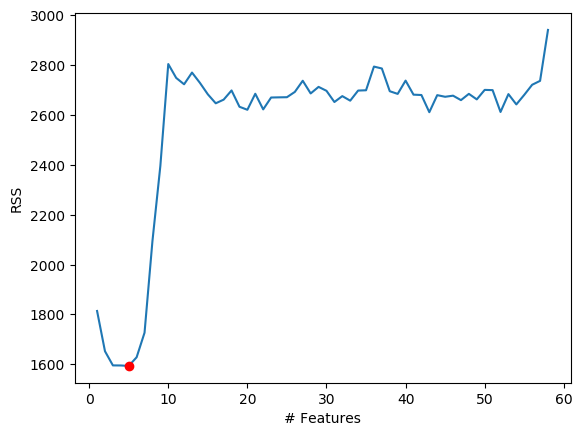

In [82]:
import matplotlib.pyplot as plt

plt.plot(models_bwd["RSS"])
plt.xlabel('# Features')
plt.ylabel('RSS')
plt.plot(models_bwd["RSS"].idxmin(), models_bwd["RSS"].min(), "or")

In [83]:
# Obtaining features of the best model according to the BSS
idx_min = models_bwd["RSS"].idxmin()
best_model_bwd = models_bwd["model"][idx_min]
best_rss_bwd = models_bwd["RSS"].min()

print(f'The best model according to the BSS is: {best_model_bwd} ({len(best_model_bwd)} features).')
print('The corresponding RSS is:', best_rss_bwd)

The best model according to the BSS is: ['Bathrooms', 'Bedrooms', 'Is Superhost', 'Property Type_Loft', 'Room Type_Entire home/apt'] (5 features).
The corresponding RSS is: 1593.6850951899457


### Principal Components Analysis (PCA)

In [100]:
pca = PCA()
X_train_reduced = pca.fit_transform(X_train_processed)

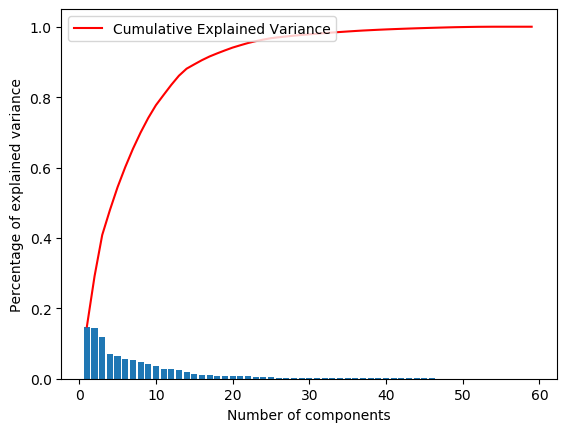

In [113]:
# Cumulative Explained Variance plot

plt.bar(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_)
plt.ylabel('Percentage of explained variance')
plt.xlabel('Number of components')
plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),
         np.cumsum(pca.explained_variance_ratio_),
         c='red',
         label="Cumulative Explained Variance")
plt.legend(loc='upper left')

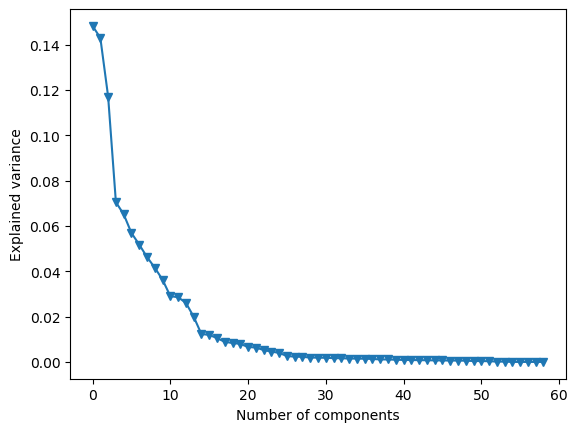

In [148]:
# Scree plot

plt.plot(pca.explained_variance_ratio_, '-v')
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.show()

In [144]:
cumulated_pve = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
print(f"Cumulated PVE for increasing numbers of components:\n{cumulated_pve}\n")

first_above_80 = list(filter(lambda x: x > 80, cumulated_pve))[0]
M = list(cumulated_pve).index(first_above_80) + 1

print("Number of components: M =", M)

Cumulated PVE for increasing numbers of components:
[ 14.83  29.13  40.84  47.89  54.41  60.1   65.28  69.91  74.07  77.7
  80.6   83.46  86.07  88.07  89.3   90.49  91.54  92.43  93.27  94.07
  94.73  95.37  95.9   96.35  96.75  97.01  97.24  97.46  97.65  97.84
  98.02  98.19  98.35  98.5   98.65  98.79  98.92  99.03  99.14  99.24
  99.33  99.41  99.49  99.56  99.63  99.69  99.75  99.81  99.87  99.91
  99.95  99.98  99.99 100.   100.   100.   100.   100.   100.  ]

Number of components: M = 11


We choose the number of principal components such that the Cumulated Proportion of Variance Explained is greater than 80%. This is obtained for $M=11$.

[2304.743601013094, 3453.6229130056263, 3296.0163065609872, 3472.0674384844597, 3432.7758030832497, 3028.6182777257245, 3192.3954987125203, 3163.6792489186105, 3313.9608192554997, 3304.3104421934213, 3536.8150440799377]


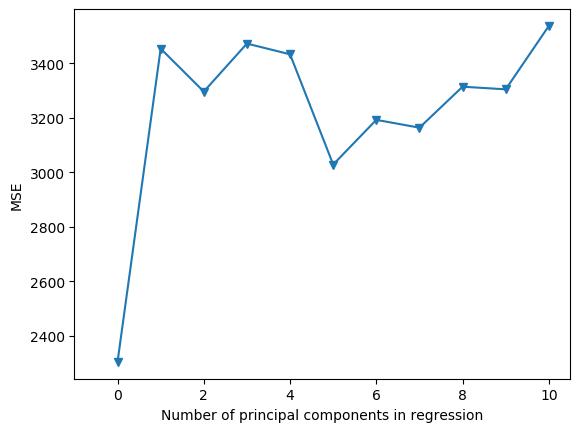

In [149]:
# 10-fold CV with shuffle
n = len(X_train_reduced)

kf_10 = model_selection.KFold(n_splits=10, shuffle=True, random_state=0)

clf = DecisionTreeRegressor()
mse = []

# Calculate MSE with only the intercept (no principal components in regression)
score = -1 * model_selection.cross_val_score(clf,
                                             np.ones((n, 1)),
                                             y_train.ravel(),
                                             cv=kf_10,
                                             scoring='neg_mean_squared_error').mean()
mse.append(score)

# Calculate MSE using CV, adding one component at the time
for i in np.arange(1, M):
    score = -1 * model_selection.cross_val_score(clf, 
                                                 X_train_reduced[:,:i], 
                                                 y_train.ravel(), 
                                                 cv=kf_10, 
                                                 scoring='neg_mean_squared_error').mean()
    mse.append(score)
    
# Plot results    
plt.plot(mse, '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.xlim(xmin=-1)

print(mse)

The results of the PCA are disappointing: we will use the results from the FSS and the BSS to reduce the dimensionality of our problem.

## Decision Tree

In [150]:
pgrid = {"max_depth": range(4, 35),
         "min_samples_split": range(100, 1001, 100)}

clf = tree.DecisionTreeClassifier()

grid_search = GridSearchCV(clf,
                           param_grid=pgrid,
                           scoring='neg_mean_squared_error',
                           cv=10)
grid_search.fit(X_train[list(best_model_fwd)], y_train)

# grid_search.best_estimator_.score(X_test, y_test)
y_predicted = grid_search.best_estimator_.predict(X_test[list(best_model_fwd)])

mse = mean_squared_error(y_test, y_predicted)
best_parameters = grid_search.best_params_

print("MSE:", mse)
print("Best parameters:", best_parameters)

/Users/Paul/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


MSE: 1373.0081859855927
Best parameters: {'max_depth': 5, 'min_samples_split': 300}


/Users/Paul/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [151]:
rmse = np.sqrt(mse)

mae = abs(y_predicted - np.array(y_test)).mean()

r2 = r2_score(np.array(y_test), y_predicted)
adjusted_r2 = 1 - (1 - r2)*((len(X_test)-1)/(len(X_test)-len(X_test.columns)-1))

print("RMSE:", rmse)
print("MAE:", mae)
print("Adjusted-R2:", adjusted_r2)

RMSE: 37.054125087304286
MAE: 21.129338572364112
Adjusted-R2: 0.3449532878916288
